In [1]:
# Import core libraries for numerical computations and data manipulation
import numpy as np
import pandas as pd

# Import tool for imputing missing values using nearest neighbors
from sklearn.impute import KNNImputer

# Import encoders for transforming categorical features
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Import utility for combining multiple transformers
from sklearn.compose import ColumnTransformer

# Import feature scaling method
from sklearn.preprocessing import MinMaxScaler

# Import data splitting function for train-test separation
from sklearn.model_selection import train_test_split
# Preprocessing tools
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Train-test split
from sklearn.model_selection import train_test_split
# Baseline Decision Tree classifier with clear evaluation and feature importances.
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load the dataset from the specified local path
data = pd.read_csv("me_cfs_vs_depression_dataset.csv")

# Display the first few rows to inspect structure and content
data.head()

,age,gender,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,work_status,social_activity_level,exercise_frequency,meditation_or_mindfulness,diagnosis
0,56,Male,8.7,3.9,9.2,8.1,10.0,6.5,9.0,7.7,0,Working,Low,Daily,Yes,Depression
1,69,Male,1.3,9.9,4.2,9.9,20.0,7.0,41.0,8.4,1,Working,Low,Often,Yes,Both
2,46,Female,4.0,5.4,4.8,NaN,24.0,1.6,13.0,6.9,0,Partially working,NaN,Rarely,Yes,Depression
3,32,Female,9.4,2.1,2.9,3.8,10.0,6.8,11.0,7.5,0,Not working,High,Never,Yes,Depression
4,60,Female,7.6,7.5,6.4,8.5,17.0,7.0,46.0,3.1,1,Not working,Low,Rarely,No,Both


In [3]:
# Extract the target column ('diagnosis') for classification
data_target = data['diagnosis']

# Remove the target column from the main dataset to isolate input features
df_features = data.drop('diagnosis', axis=1)

# Select only numerical features from the dataset
numerical_data = data.select_dtypes(['number'])

# Select only non-numerical (categorical/text) features from the dataset
non_numerical_data = data.select_dtypes(exclude=['number'])

In [4]:
# Print missing values in each section with clear labeling
print("Missing values in numerical features:\n", numerical_data.isna().sum())
print("\nMissing values in categorical features:\n", non_numerical_data.isnull().sum())

Missing values in numerical features:
 age                              0
sleep_quality_index             47
brain_fog_level                 48
physical_pain_score             34
stress_level                    48
depression_phq9_score           22
fatigue_severity_scale_score    21
pem_duration_hours              24
hours_of_sleep_per_night        21
pem_present                      0
dtype: int64

Missing values in categorical features:
 gender                        0
work_status                  47
social_activity_level        40
exercise_frequency           39
meditation_or_mindfulness    11
diagnosis                     0
dtype: int64


In [5]:
# Define a flexible ordinal encoding function for a single categorical column
def label_encoder(data, column, cat='auto'):
    # If custom categories are provided, ensure they are wrapped in a list
    if cat != 'auto':
        cat = [cat]   
    
    # Initialize OrdinalEncoder with optional category list and NaN encoding
    ordinal_encode = OrdinalEncoder(categories=cat, encoded_missing_value=np.nan)
    
    # Apply encoding to the selected column and return encoded values + category mapping
    transform_column = ordinal_encode.fit_transform(data[[column]])
    return transform_column, ordinal_encode.categories_


In [6]:
# Apply ordinal encoding to the 'work_status' column and retrieve category mapping
work_labels, categorie = label_encoder(non_numerical_data, column='work_status')

# Add the encoded 'work_status' values into the numerical feature set
numerical_data['work_status'] = work_labels
print("Encoded categories for work_status:", categorie)

Encoded categories for work_status: [array(['Not working', 'Partially working', 'Working', nan], dtype=object)]


In [7]:
# Define custom ordered categories for 'social_activity_level'
cat_activity = ['Very low', 'Low', 'Medium', 'High', 'Very high', np.nan]

# Apply custom ordinal encoding using the specified category order
social_activity_level_labels, categorie_so = label_encoder(
    non_numerical_data, column='social_activity_level', cat=cat_activity
)

# Add the encoded values back to the numerical feature set
numerical_data['social_activity_level'] = social_activity_level_labels

In [8]:
# Define custom ordinal categories for 'exercise_frequency'
cat_ex = ['Daily', 'Never', 'Often', 'Rarely', 'Sometimes', np.nan]

# Apply ordinal encoding using the specified category order
exercise_frequency_labels, categorie_ex = label_encoder(
    non_numerical_data, column='exercise_frequency', cat=cat_ex
)

# Add encoded 'exercise_frequency' values into the numerical feature set
numerical_data['exercise_frequency'] = exercise_frequency_labels

In [9]:
label_maps = {
    'work_status': categorie,
    'social_activity_level': categorie_so,
    'exercise_frequency': categorie_ex
}
print(label_maps)

{'work_status': [array(['Not working', 'Partially working', 'Working', nan], dtype=object)], 'social_activity_level': [array(['Very low', 'Low', 'Medium', 'High', 'Very high', nan],
      dtype=object)], 'exercise_frequency': [array(['Daily', 'Never', 'Often', 'Rarely', 'Sometimes', nan],
      dtype=object)]}


In [10]:
print(non_numerical_data['meditation_or_mindfulness'].unique())


['Yes' 'No' nan]


In [11]:
# Apply ordinal encoding to 'meditation_or_mindfulness' using default category detection
meditation_or_mindfulness_labels, categorie_medi = label_encoder(
    non_numerical_data, column='meditation_or_mindfulness'
)

# Add the encoded values into the numerical feature set
numerical_data['meditation_or_mindfulness'] = meditation_or_mindfulness_labels

In [12]:
# One-Hot Encode the 'gender' column:
# - We use OneHotEncoder from sklearn to safely convert the categorical 'gender' values into binary columns.
# - The 'handle_unknown' parameter ensures new/unseen categories won't break the code during inference.
# - Setting 'sparse_output=False' makes the output a dense array, which we convert into a DataFrame.
# - We assign clear column names like 'gender_male', 'gender_female' etc., and align the index for merging.
# - Finally, we concatenate the new encoded columns with the numerical dataset.

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
gender_ohe = ohe.fit_transform(non_numerical_data[['gender']])
gender_ohe_df = pd.DataFrame(
    gender_ohe,
    columns=[f"gender_{c}" for c in ohe.categories_[0]],
    index=non_numerical_data.index
)
numerical_data = pd.concat([numerical_data, gender_ohe_df], axis=1)


In [13]:
# KNN-impute missing numeric values and keep the DataFrame structure intact.
# Notes:
# - KNNImputer uses (NaN-aware) Euclidean distances between rows; features on larger scales dominate.
# - Fit the imputer on TRAIN ONLY to avoid data leakage, then transform both train and test.
# - After fit_transform, the result is a NumPy array; we reconstruct a DataFrame with original columns and index.

# 1) Keep original column names and index for reconstruction after transform
data_alg_columns = numerical_data.columns
data_alg_index   = numerical_data.index

# 2) Configure the imputer
#    - missing_values=np.nan: treat NaN as missing
#    - n_neighbors=5: average of 5 nearest rows (tune this if needed)
#    - weights='uniform' (default): all neighbors equal; try 'distance' to weight closer neighbors more
knn_impute = KNNImputer(missing_values=np.nan, n_neighbors=5)

# 3) Fit on the dataset and transform it
#    IMPORTANT: In a real pipeline, do: imputer.fit(X_train_num); imputer.transform(X_train_num); imputer.transform(X_test_num)
numerical_imputed = knn_impute.fit_transform(numerical_data)

# 4) Rebuild a DataFrame with original schema
numerical_data = pd.DataFrame(numerical_imputed, columns=data_alg_columns, index=data_alg_index)

In [14]:
# One-Hot Encode the 'work_status' feature after rounding values up to nearest integer.
# - We apply np.ceil() to ensure all fractional encoded values become whole numbers (e.g. 0.3 → 1).
# - Fit OneHotEncoder on the column to create binary indicators for each work status category.
# - Convert the sparse matrix to a dense NumPy array for slicing and merging.
# - Add new columns: 'not_working', 'partially_working', 'working' corresponding to encoded categories.
# - Drop the original 'work_status' column after encoding to avoid duplication.

numerical_data['work_status'] = np.ceil(numerical_data['work_status'])

ohe_work_status = OneHotEncoder()
ohe_w = ohe_work_status.fit_transform(numerical_data[['work_status']])

numerical_data['not_working']        = ohe_w.toarray()[:, 0]
numerical_data['partially_working']  = ohe_w.toarray()[:, 1]
numerical_data['working']            = ohe_w.toarray()[:, 2]

numerical_data = numerical_data.drop('work_status', axis=1)

In [15]:
# Round exercise frequency values up to ensure consistency before encoding
numerical_data['exercise_frequency'] = np.ceil(numerical_data['exercise_frequency'])

# Initialize a new OneHotEncoder instance (don't reuse ohe_work_status)
ohe_exercise_frequency = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the rounded 'exercise_frequency' column
ohe_ex = ohe_exercise_frequency.fit_transform(numerical_data[['exercise_frequency']])

# Retrieve the encoded category labels
cat_ex = ohe_exercise_frequency.categories_[0]

# Add each encoded category as a separate column with clear naming
numerical_data[f"exercise_frequency_{cat_ex[0]}"] = ohe_ex[:, 0]
numerical_data[f"exercise_frequency_{cat_ex[1]}"] = ohe_ex[:, 1]
numerical_data[f"exercise_frequency_{cat_ex[2]}"] = ohe_ex[:, 2]
numerical_data[f"exercise_frequency_{cat_ex[3]}"] = ohe_ex[:, 3]
numerical_data[f"exercise_frequency_{cat_ex[4]}"] = ohe_ex[:, 4]

# Drop original 'exercise_frequency' column to avoid redundancy
numerical_data = numerical_data.drop('exercise_frequency', axis=1)

In [16]:
# One-Hot Encode the 'meditation_or_mindfulness' feature after rounding to clean binary format
# - np.ceil ensures fractional values (e.g., 0.3) become whole (1.0) before encoding
# - OneHotEncoder is used to convert binary categories into two separate columns
# - Each column represents presence (Yes = 1) or absence (No = 0) of meditation/mindfulness activity
# - The original feature is dropped to prevent duplication

numerical_data['meditation_or_mindfulness'] = np.ceil(numerical_data['meditation_or_mindfulness'])

ohe_meditation_or_mindfulness = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
meditation = ohe_meditation_or_mindfulness.fit_transform(numerical_data[['meditation_or_mindfulness']])

numerical_data['no_meditation_or_mindfulness']  = meditation[:, 0]
numerical_data['yes_meditation_or_mindfulness'] = meditation[:, 1]

numerical_data = numerical_data.drop('meditation_or_mindfulness', axis=1)

In [17]:
# Apply Min-Max scaling to the first 10 numeric features
# - We convert the DataFrame 'numerical_data' to a NumPy array for slicing convenience.
# - MinMaxScaler scales each feature individually to a given range (0 to 1 here).
# - Only columns 0 to 9 are scaled — useful for early feature selection or experimentation.

n = np.array(numerical_data)

scaler = MinMaxScaler(feature_range=(0, 1))
n1 = scaler.fit_transform(n[:, 0:10])  # scale only the first 10 columns
data_for_algoritm = pd.DataFrame(n , columns=numerical_data.columns)

In [18]:
# Add the target column (diagnosis) to the final DataFrame
data_for_algoritm['target'] = data_target

# Split into train and test sets with stratification based on target classes
# - Stratify ensures equal distribution of diagnosis classes across train/test
# - test_size=150 creates a fixed-size test set for evaluation
# - Use random_state for reproducibility

train_data, test_data = train_test_split(
    data_for_algoritm,
    test_size=150,
    stratify=data_for_algoritm['target'],
    #random_state=40  # optional: ensures consistent splits across runs
)

In [19]:
# Reset training data index and clean up the DataFrame
# - reset_index(): assigns a fresh sequential index and keeps the old one as 'index'
# - We extract the 'target' column again (in case it was added back or reset during preprocessing)
# - Drop both 'target' and the old 'index' column to finalize the clean input feature matrix

train_data = train_data.reset_index()
train_data_target = train_data['target']
train_data = train_data.drop(['target', 'index'], axis=1)

train_data  # Finalized training feature set


,age,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,...,not_working,partially_working,working,exercise_frequency_0.0,exercise_frequency_1.0,exercise_frequency_2.0,exercise_frequency_3.0,exercise_frequency_4.0,no_meditation_or_mindfulness,yes_meditation_or_mindfulness
0,61.0,9.20,6.3,2.1,2.60,20.0,7.0,37.0,8.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,29.0,4.00,9.2,1.2,8.10,10.0,7.0,1.0,9.1,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,28.0,5.30,5.1,8.5,3.90,21.0,7.0,1.0,9.1,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,43.0,7.60,2.1,3.5,6.30,10.0,7.9,8.0,5.1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,24.0,1.80,9.2,1.5,4.90,9.0,8.7,36.0,6.2,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,25.0,4.90,7.1,8.6,3.30,10.0,8.0,3.0,9.3,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
846,62.0,6.00,3.2,4.6,2.90,22.0,1.5,45.0,9.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
847,18.0,4.82,5.6,5.0,2.80,10.0,9.5,3.0,9.9,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
848,62.0,4.70,8.4,2.4,6.10,26.0,7.2,28.0,8.7,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
# Reset index for the test data and clean it up
# - We assign a fresh index and recover the target labels from the 'target' column
# - Then we drop the 'target' and 'index' columns to finalize the feature matrix for prediction

test_data = test_data.reset_index()
test_data_target = test_data['target']
test_data = test_data.drop(['target', 'index'], axis=1)
test_data  # Finalized testing feature set

,age,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,...,not_working,partially_working,working,exercise_frequency_0.0,exercise_frequency_1.0,exercise_frequency_2.0,exercise_frequency_3.0,exercise_frequency_4.0,no_meditation_or_mindfulness,yes_meditation_or_mindfulness
0,69.0,1.3,9.9,4.2,9.90,20.0,7.0,41.0,8.4,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,55.0,4.4,5.2,6.3,6.90,2.0,8.1,43.0,3.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,20.0,3.6,2.2,7.2,2.10,14.0,1.3,31.0,8.9,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,23.0,2.4,4.6,1.3,9.70,19.0,2.7,43.0,3.8,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,24.0,3.8,3.0,6.2,10.00,13.0,1.4,36.0,3.7,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,62.0,5.7,2.4,8.0,7.18,10.8,8.0,14.0,9.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
146,59.0,9.4,8.1,2.5,3.30,17.0,7.4,12.0,6.6,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
147,37.0,4.9,2.9,5.0,3.90,2.0,9.8,32.0,6.6,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
148,49.0,5.0,4.1,1.8,5.10,10.0,4.8,12.0,8.1,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
# Initialize a baseline Decision Tree classifier
# - random_state: ensures reproducible results
# - You can later tune depth/leaf settings to reduce overfitting
dtree = DecisionTreeClassifier(
    criterion='gini',
    #random_state=40,
    min_impurity_decrease=0.05,
    # max_depth=8,
    # min_samples_split=10,
    # min_samples_leaf=5,
    # class_weight='balanced',  # uncomment if classes are imbalanced
)

# Fit the model on the training features and labels
dt = dtree.fit(train_data, train_data_target)

In [22]:
# Convert the test feature matrix and target vector to NumPy arrays
# - to_numpy() is the preferred, explicit way to get NumPy arrays from pandas
# - Keep 'test_data' as a DataFrame if you want to retain column names (useful for importances)
# - Ensure the target is 1D for sklearn metrics

test = test_data.to_numpy()
test_target = test_data_target.to_numpy().ravel()  # ravel to guarantee 1D

In [23]:
# Predict target labels for the test set using the trained Decision Tree
# - Each value in 'predictions' corresponds to a sample in 'test_data'
# - You can compare it to 'test_data_target' to evaluate performance

predictions = dt.predict(test_data)

# View the first few predictions
print("Sample predictions:", predictions[:10])

Sample predictions: ['Both' 'ME/CFS' 'Depression' 'Depression' 'Depression' 'Depression'
 'Depression' 'ME/CFS' 'Depression' 'ME/CFS']


In [24]:
# Evaluate model predictions with confusion matrix and classification report
# - 'confusion_matrix' shows prediction breakdown across true vs predicted classes
# - 'classification_report' gives precision, recall, F1-score (macro, weighted, etc.)
# - Use this for both accuracy insight and class imbalance analysis

print(confusion_matrix(test_target, predictions))
print(classification_report(test_target, predictions))

[[30  0  0]
 [ 0 60  0]
 [ 1  0 59]]
              precision    recall  f1-score   support

        Both       0.97      1.00      0.98        30
  Depression       1.00      1.00      1.00        60
      ME/CFS       1.00      0.98      0.99        60

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [25]:
# Import the function to visualize Decision Trees and the plotting library
# - plot_tree from sklearn allows us to display the structure of the fitted tree
# - matplotlib.pyplot is the core plotting tool used for rendering

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

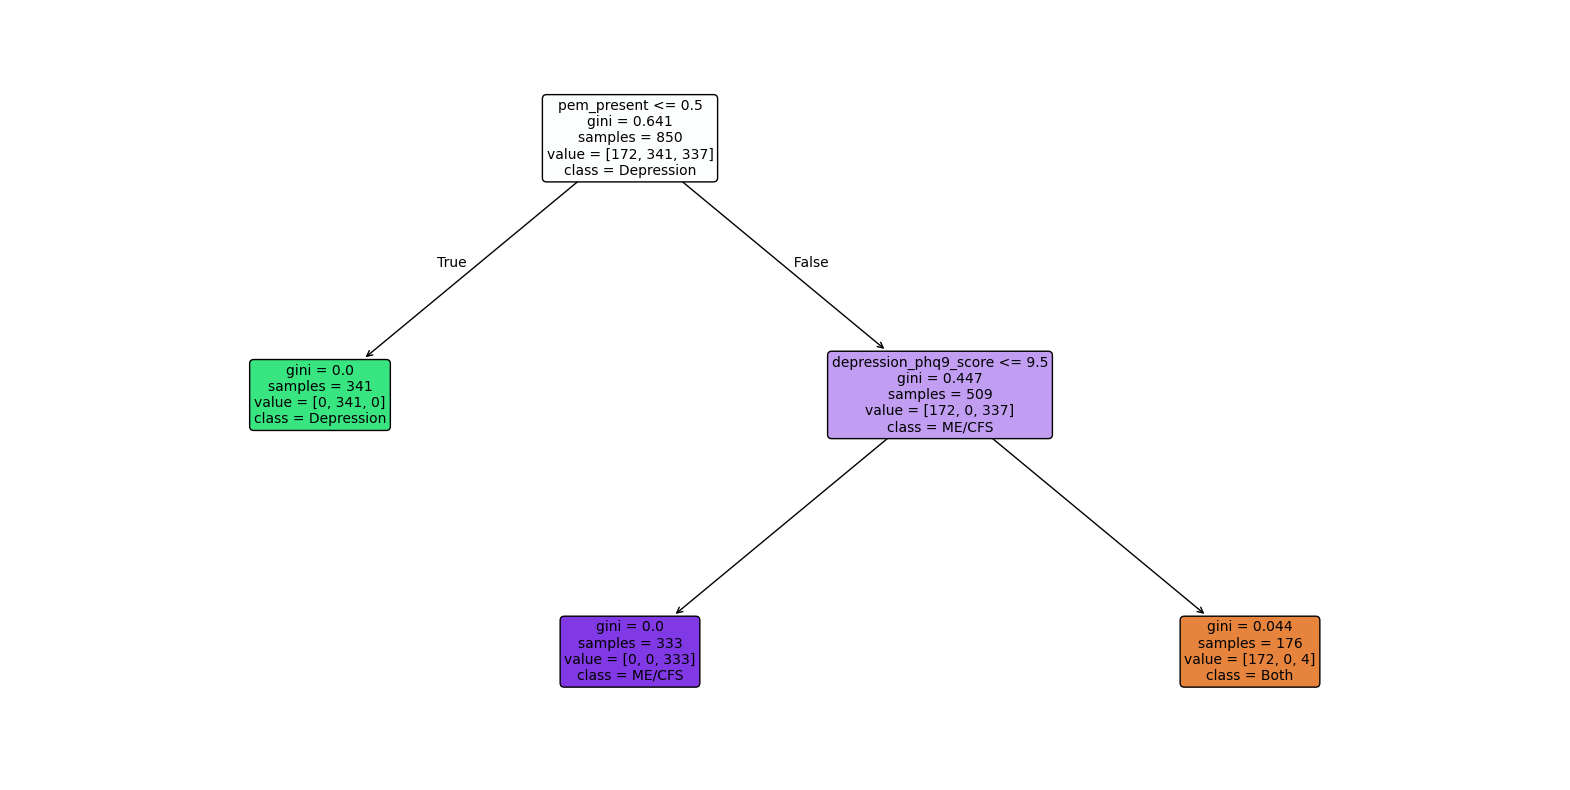

In [26]:
# Visualize the trained Decision Tree model with detailed configuration
# - figsize=(20, 10): sets a wide layout for readability
# - plot_tree(): displays the tree structure including splits and leaf outcomes
# - feature_names: names of input features shown in each node
# - class_names: label names shown in leaf nodes (diagnosis classes)
# - filled=True: colors nodes based on predicted class for easy tracking
# - rounded=True and fontsize=10: improve the aesthetics and text clarity

plt.figure(figsize=(20, 10))
plot_tree(dt, 
          feature_names=train_data.columns,  # or a list of selected features
          class_names=dt.classes_, 
          filled=True, 
          rounded=True, 
          fontsize=10)

plt.show()  # render the plot

finish